In [13]:
%matplotlib inline
import os
import sys
import copy
import pickle
import numpy
import time
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.pyplot import figure, subplots, imshow, xticks, yticks, title
from sklearn.metrics import confusion_matrix
from sklearn.metrics.cluster import mutual_info_score
from sklearn.cluster import KMeans
from statistics import mean
from scipy.stats import entropy
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from statistics import mean
import matplotlib.pyplot as plt



In [7]:
common_length = 10
# Given arrays
array_A = np.full(common_length, 0.5)
array_B = np.full(common_length, 0.5)
array_C = np.full(common_length, 0.5)

# Random index for array A
index_A = np.random.randint(common_length)
value_A = np.random.choice([0, 1])
array_A[index_A] = value_A

# Different random index for array B
indices_B = np.delete(
    np.arange(common_length), index_A
)  # Removing the index used in Array A
index_B = np.random.choice(indices_B)
value_B = np.random.choice([0, 1])
array_B[index_B] = value_B

# Setting the last index of array C to either 0 or 1
value_C = np.random.choice([0, 1])
array_C[-1] = value_C

# Generating label based on value_C
# Perform XOR if C is 0, perform XNOR if C is 1
label = int((value_A != value_B) if value_C == 0 else (value_A == value_B))

# Outputting the arrays and the label
array_A, array_B, array_C, label

(array([0.5, 0.5, 0.5, 0.5, 0.5, 0. , 0.5, 0.5, 0.5, 0.5]),
 array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0. , 0.5, 0.5, 0.5]),
 array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0. ]),
 0)

In [8]:
# Creating a DataFrame with the arrays
df = pd.DataFrame({"Array A": array_A, "Array B": array_B, "Array C": array_C})
df

,Array A,Array B,Array C
0,0.5,0.5,0.5
1,0.5,0.5,0.5
2,0.5,0.5,0.5
3,0.5,0.5,0.5
4,0.5,0.5,0.5
5,0.0,0.5,0.5
6,0.5,0.0,0.5
7,0.5,0.5,0.5
8,0.5,0.5,0.5
9,0.5,0.5,0.0


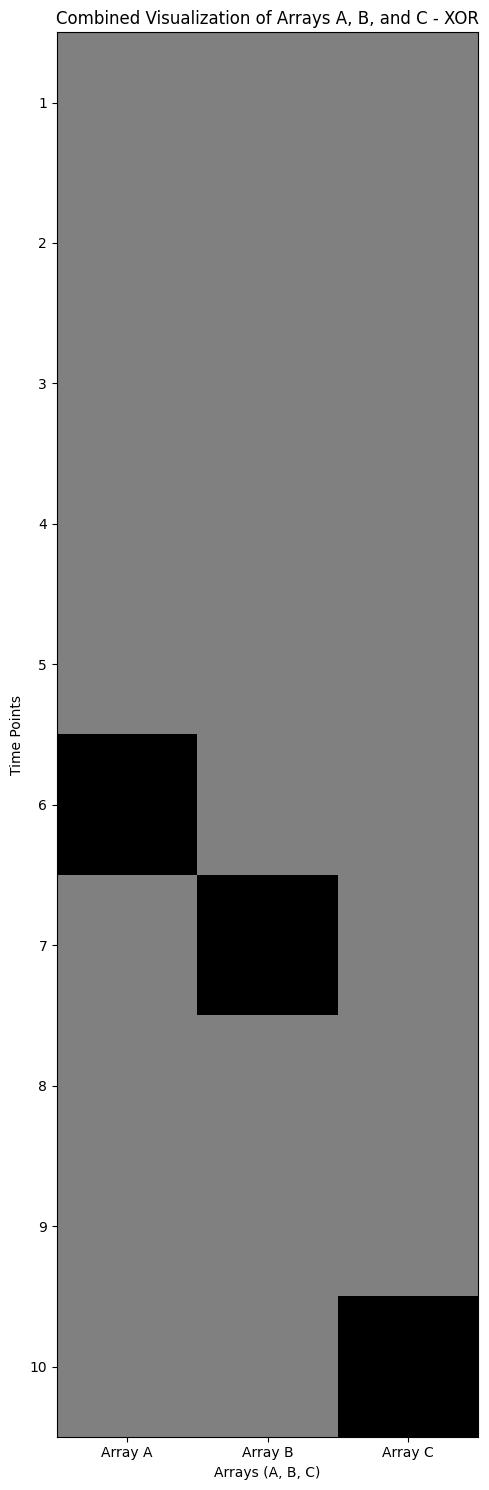

In [9]:
# Assuming array_A, array_B, array_C are defined as in your previous code
reshaped_A = array_A.reshape(-1, 1)
reshaped_B = array_B.reshape(-1, 1)
reshaped_C = array_C.reshape(-1, 1)

# Combining the reshaped arrays into a single array for visualization
combined_array = np.hstack([reshaped_A, reshaped_B, reshaped_C])

# Determining the label for the title
label = array_C[-1]  # Last element of Array C
operation_title = "XOR" if label == 0 else "AND"

# Plotting
plt.figure(figsize=(15, 15))

# Displaying the combined array
ax = plt.imshow(combined_array, cmap="gray", vmin=0.0, vmax=1.0)

# Setting the title with the operation label
plt.title(f"Combined Visualization of Arrays A, B, and C - {operation_title}")

# Setting labels for features (X-axis) and detailed time points (Y-axis)
plt.xlabel("Arrays (A, B, C)")
plt.ylabel("Time Points")

# Setting tick marks for each time point on the Y-axis
plt.yticks(
    range(combined_array.shape[0]), [f"{j+1}" for j in range(combined_array.shape[0])]
)

# Setting tick marks for each array on the X-axis
plt.xticks(range(3), ["Array A", "Array B", "Array C"])

plt.tight_layout()
plt.show()

In [54]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim**0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
        return weighted


class NetRNNWithAttention(nn.Module):
    def __init__(self, hidden_dim=12, inp=3):
        super(NetRNNWithAttention, self).__init__()
        self.attention = SelfAttention(inp)  # Attention layer with input dimension
        self.rnnLayer = nn.RNN(inp, hidden_dim, batch_first=True)
        self.outputLayer = nn.Linear(hidden_dim, 1)
        self.hidden_dim = hidden_dim
        self.inp = inp
        self.resetHidden()

    def resetHidden(self):
        self.hidden = list()

    def forward(self, x):
        # Applying attention first
        attn_out = self.attention(x)

        # Feeding the output of the attention layer into the RNN
        h0 = torch.zeros(1, x.shape[0], self.hidden_dim)
        rnn_out, _ = self.rnnLayer(attn_out, h0)
        rnn_out = torch.tanh(rnn_out)

        # Applying the final output layer
        out = torch.sigmoid(self.outputLayer(rnn_out[:, -1, :])).squeeze()
        return out

    def step(self, x):
        O = []
        H = []
        for l in range(x.shape[0]):
            h0 = torch.zeros(1, 1, self.hidden_dim)
            for i in range(x.shape[1]):
                # Applying attention to each timestep
                attn_out = self.attention(x[l][i].reshape((1, 1, self.inp)))

                # Feeding the output of the attention layer into the RNN
                out, h0 = self.rnnLayer(attn_out, h0)
                H.append(out.detach().numpy().flatten())

                out = torch.tanh(out)
                out = torch.sigmoid(self.outputLayer(out[:, -1, :]))
                O.append(out.detach().numpy().flatten())

        return np.array(O), np.array(H)


model = NetRNNWithAttention()

In [30]:
def generateTrainData(num_samples, min_length, max_length):
    s = []  # Sequences (list of arrays)
    t = []  # Targets (list of labels)

    for _ in range(num_samples):
        # Randomized common length between min_length and max_length
        common_length = np.random.Generator(bit_generator)(min_length, max_length + 1)

        # Given arrays
        array_A = np.full(common_length, 0.5)
        array_B = np.full(common_length, 0.5)
        array_C = np.full(common_length, 0.5)

        # Random index for array A
        index_A = np.random.randint(common_length)
        value_A = np.random.choice([0, 1])
        array_A[index_A] = value_A

        # Different random index for array B
        indices_B = np.delete(
            np.arange(common_length), index_A
        )  # Removing the index used in Array A
        index_B = np.random.choice(indices_B)
        value_B = np.random.choice([0, 1])
        array_B[index_B] = value_B

        # Setting the last index of array C to either 0 or 1
        value_C = np.random.choice([0, 1])
        array_C[-1] = value_C

        # Generating label based on value_C
        label = int((value_A != value_B) if value_C == 0 else (value_A == value_B))
        label_arr = [label]
        # Combine arrays
        combined_array = np.vstack([array_A, array_B, array_C]).T

        s.append(combined_array)
        t.append(label_arr)

    return s, numpy.array(t, float64)  # Returning as lists

In [31]:
num_seq = 2
array_min_length = 5
array_max_length = 10
sequences, labels = generateTrainData(num_seq, array_min_length, array_max_length)
sequences, labels

([array([[1. , 0.5, 0.5],
         [0.5, 0. , 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 1. ]]),
  array([[0. , 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 0.5, 0.5],
         [0.5, 1. , 1. ]])],
 array([[0],
        [0]]))

In [32]:
print(len(sequences[0]))
print(len(sequences[1]))

8
5


In [35]:
model = NetRNNWithAttention()
sequences, labels = generateTrainData(100, 10, 10)
output = model(torch.Tensor(sequences))
print(output.shape)
print(model)

torch.Size([100])
NetRNNWithAttention(
  (attention): SelfAttention(
    (query): Linear(in_features=3, out_features=3, bias=True)
    (key): Linear(in_features=3, out_features=3, bias=True)
    (value): Linear(in_features=3, out_features=3, bias=True)
    (softmax): Softmax(dim=2)
  )
  (rnnLayer): RNN(3, 12, batch_first=True)
  (outputLayer): Linear(in_features=12, out_features=1, bias=True)
)


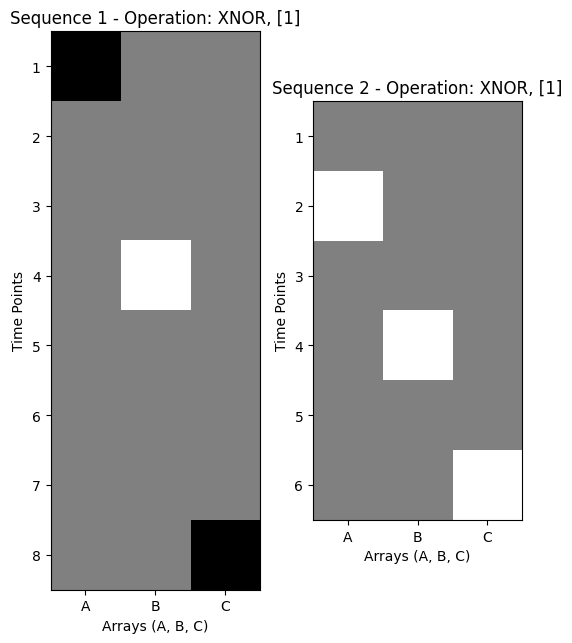

In [18]:
# Assuming sequences and labels are already generated using generateTrainData
num_samples = len(sequences)  # Number of samples to display

# Plotting
# Adjust the figure size to accommodate horizontal layout
plt.figure(figsize=(3 * num_samples, 15))

for i, (seq, label) in enumerate(zip(sequences, labels)):
    # Reshape each sequence for visualization
    reshaped_sequence = seq  # Use the sequence as it is

    # Add a subplot for each sequence in a horizontal layout
    ax = plt.subplot(1, num_samples, i + 1)
    img = ax.imshow(reshaped_sequence, cmap="gray", vmin=0.0, vmax=1.0)

    # Determine the operation title based on the label
    operation_title = "XOR" if label == 0 else "XNOR"

    # Setting the title with the operation label
    ax.set_title(f"Sequence {i+1} - Operation: {operation_title}, {label}")

    # Setting labels for features (X-axis) and detailed time points (Y-axis)
    ax.set_xlabel("Arrays (A, B, C)")
    ax.set_ylabel("Time Points")

    # Setting tick marks for each array on the X-axis
    ax.set_xticks(range(3))
    ax.set_xticklabels(["A", "B", "C"])

    # Setting tick marks for each time point on the Y-axis
    # Here, the number of ticks should be equal to the length of the sequence (number of rows)
    ax.set_yticks(range(reshaped_sequence.shape[0]))
    ax.set_yticklabels([f"{j+1}" for j in range(reshaped_sequence.shape[0])])

# Adding a colorbar as the key, placed at the side
# cbar_ax = plt.gcf().add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust these values as needed for positioning
# cbar = plt.colorbar(img, cax=cbar_ax)
# cbar.set_ticks([0, 1])
# cbar.set_ticklabels(['0 (Black)', '1 (White)'])

# Adjust the main figure to make room for the colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

In [ ]:
collectorA = dict()
array_min_length = 5  # Define the min length of Arrays A, B, C
array_max_length = 10  # Define the max length of Arrays A, B, C

for rep in range(1):
    model = NetRNNWithAttention(hidden_dim=12)
    optimizer = optim.Adam(model.parameters())
    error = nn.MSELoss()
    acc = 0.0
    W = []
    A = []

    while acc < 0.97:
        model.resetHidden()
        sequences, targets = generateTrainData(2, array_min_length, array_max_length)
        sequences = numpy.array(sequences)  # Convert to numpy array

        divs = []
        for seq, target in zip(sequences, targets):
            optimizer.zero_grad()
            # Process each sequence individually
            seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(
                0
            )  # Add batch dimension
            target_tensor = torch.tensor(
                target, dtype=torch.float32
            )  # Add batch dimension

            output = model(torch.Tensor(seq.reshape(1, seq.shape[0], 3)))
            loss = error(output, target_tensor)
            loss.backward()
            optimizer.step()

            div = output.detach().numpy() - target_tensor.numpy()
            divs.append(1.0 - abs(div).mean())

        W.append(loss.item())
        acc = mean(divs)
        A.append(acc)
        print(f"acc: {acc}")

        # Restart training if not converging
        if acc < 0.97 and len(A) > 2000:
            model = NetRNNWithAttention(hidden_dim=12)
            optimizer = optim.Adam(model.parameters())
            acc = 0.0
            W = []
            A = []
            print("repeat")

    print(f"RNN {rep}", len(A))

Analysis - Step Function Outputs: Mean = [0.5189079], Std Dev = [0.00362937]
Analysis - Step Function Hidden States: Mean = [ 0.18869855  0.3534941  -0.00488805  0.22317414  0.34872916  0.46057042
 -0.42312843 -0.58057594  0.22702646  0.3351711  -0.24881074 -0.3559864 ], Std Dev = [0.04994172 0.09944471 0.05966627 0.05106605 0.09811156 0.11482479
 0.0408665  0.1081535  0.06297682 0.1457329  0.06330218 0.08192197]


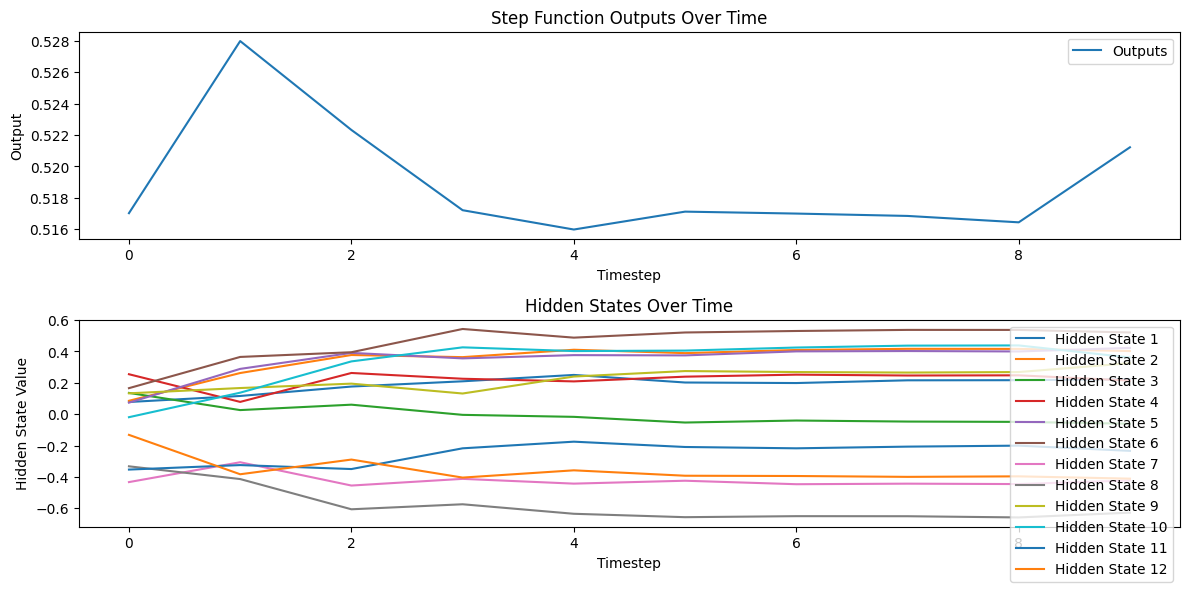

Analysis - Step Function Outputs: Mean = [0.4874281], Std Dev = [0.00294291]
Analysis - Step Function Hidden States: Mean = [ 0.03556395 -0.02851568  0.15379089  0.20925501  0.03344901  0.11973472
 -0.04914689 -0.0914949   0.13163444  0.21940342 -0.13321885 -0.23991823], Std Dev = [0.03526427 0.02634721 0.01734732 0.04361841 0.04234729 0.0379438
 0.04424547 0.04653085 0.03837162 0.07183856 0.05238831 0.04197763]


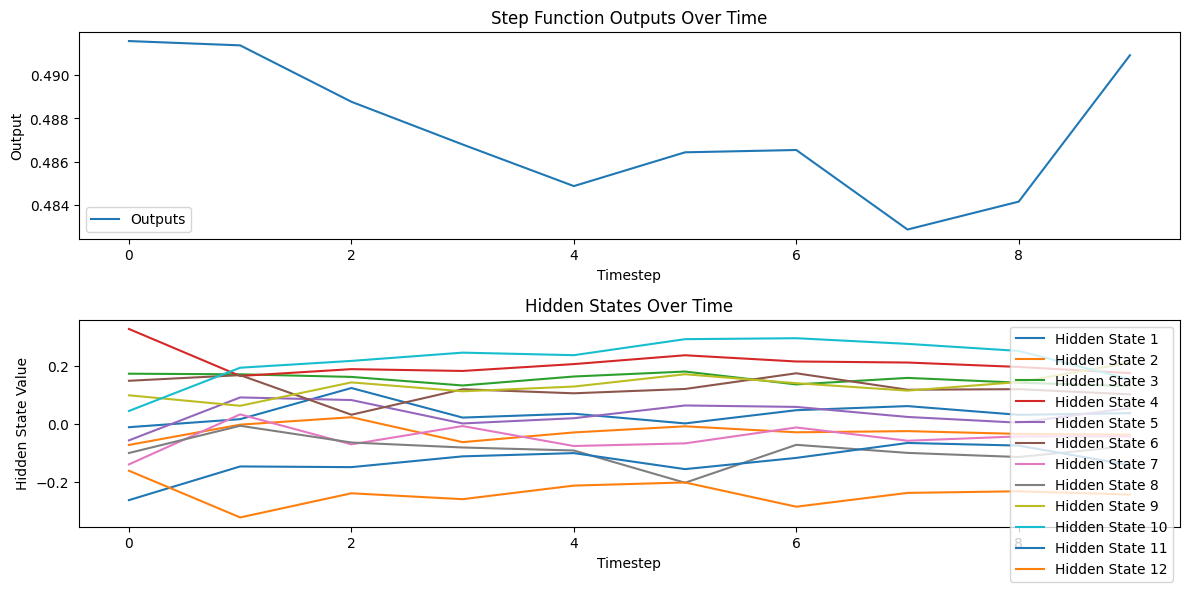

Analysis - Step Function Outputs: Mean = [0.50258017], Std Dev = [0.00493256]
Analysis - Step Function Hidden States: Mean = [ 0.05001485 -0.00938608  0.07595219  0.15437175 -0.04121393  0.06121732
 -0.10058296 -0.05550139  0.00729921  0.09532958 -0.24525335 -0.14434636], Std Dev = [0.02913496 0.03061554 0.04626691 0.07120933 0.05017426 0.04362813
 0.10835341 0.05563848 0.05468554 0.05738854 0.04385651 0.06500481]


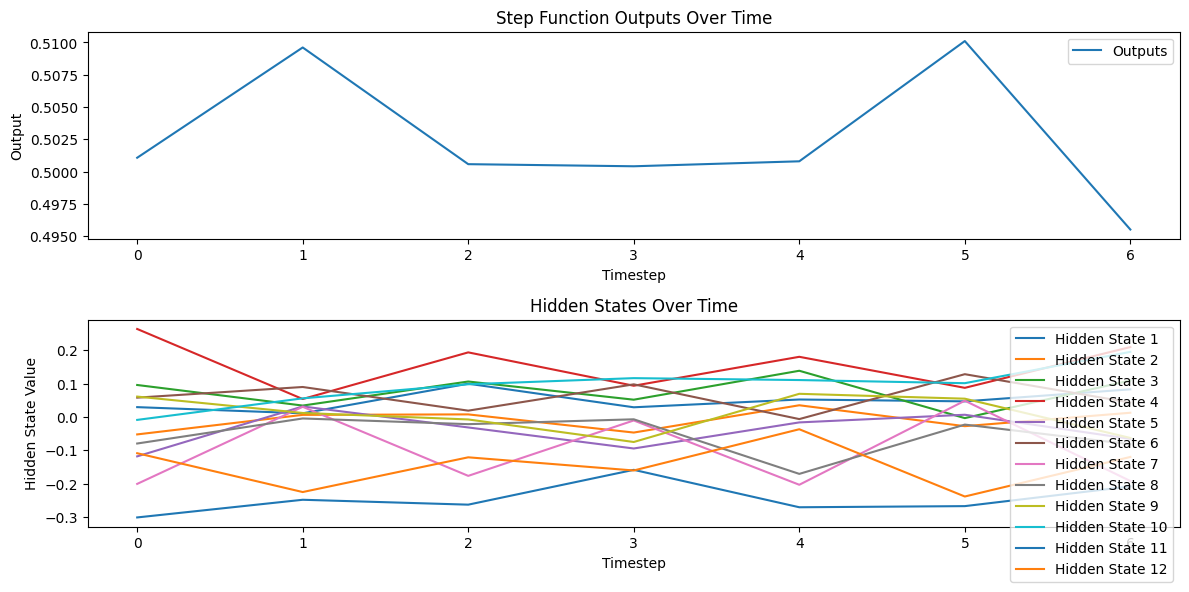

Analysis - Step Function Outputs: Mean = [0.50855285], Std Dev = [0.00299406]
Analysis - Step Function Hidden States: Mean = [ 0.04647553 -0.01072289  0.0208461   0.10157075 -0.06489863 -0.00801163
 -0.03016638  0.01284606  0.01839012  0.00271692 -0.30129084 -0.13228424], Std Dev = [0.02572204 0.02890253 0.02316831 0.06185102 0.04191547 0.01693428
 0.04304754 0.06130375 0.03520347 0.05023443 0.01869703 0.03874878]


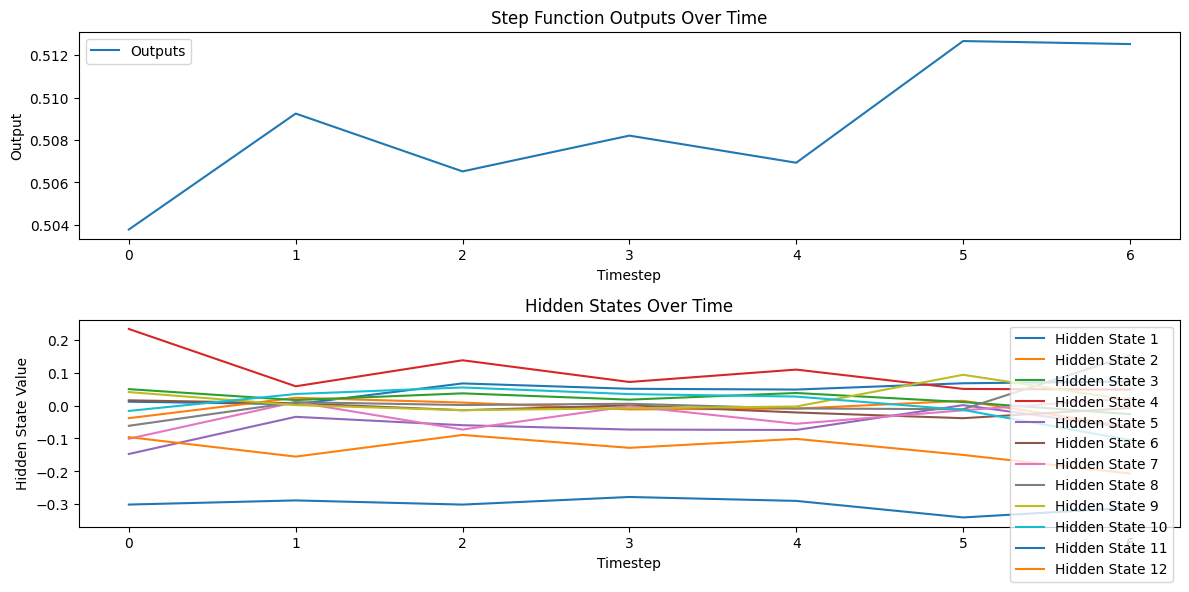

Analysis - Step Function Outputs: Mean = [0.5271749], Std Dev = [0.00475145]
Analysis - Step Function Hidden States: Mean = [ 0.06142444 -0.02633281  0.02818049  0.08455738  0.14576721  0.01712782
  0.0314163  -0.04192933  0.04681546 -0.01469966 -0.3954725  -0.14048393], Std Dev = [0.04809938 0.0261287  0.04572308 0.05125473 0.10098691 0.053664
 0.03498233 0.05966619 0.07652141 0.08067429 0.0600797  0.04159846]


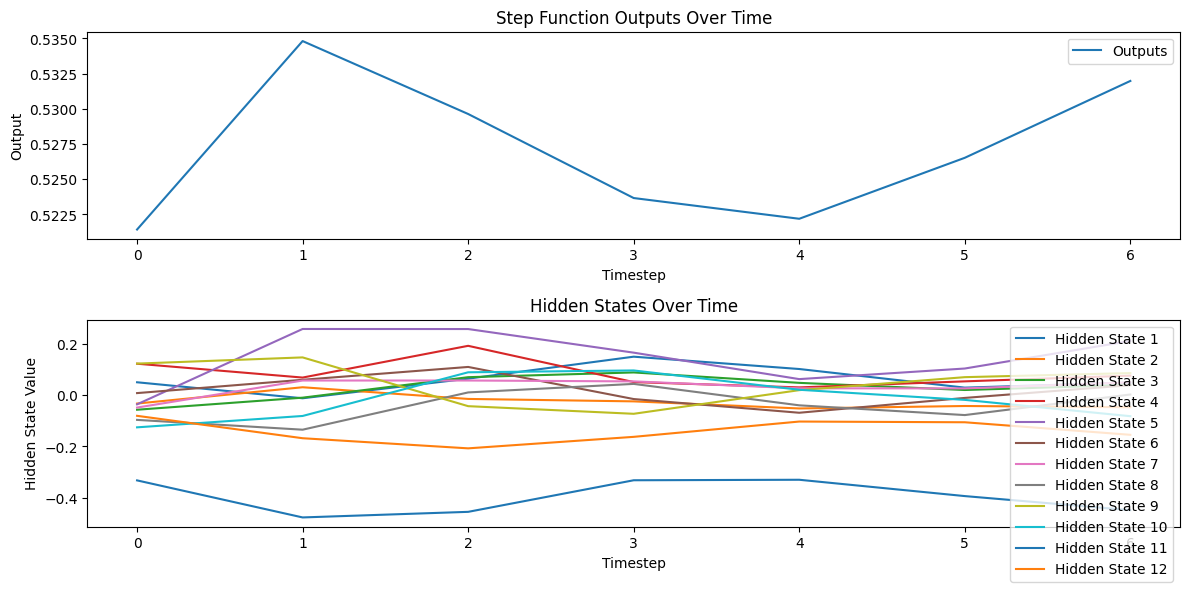

repeat
acc: 0.0
Analysis - Step Function Outputs: Mean = [0.48710236], Std Dev = [0.00485088]
Analysis - Step Function Hidden States: Mean = [-0.17404693  0.18182886  0.09417321 -0.02411809 -0.06901683  0.02423054
  0.54695356  0.06893814 -0.17382409  0.62170815  0.02955379  0.03617865], Std Dev = [0.08055308 0.0354006  0.03712231 0.03828066 0.03148248 0.05258872
 0.0319863  0.08810879 0.02562243 0.04602438 0.041072   0.09115867]


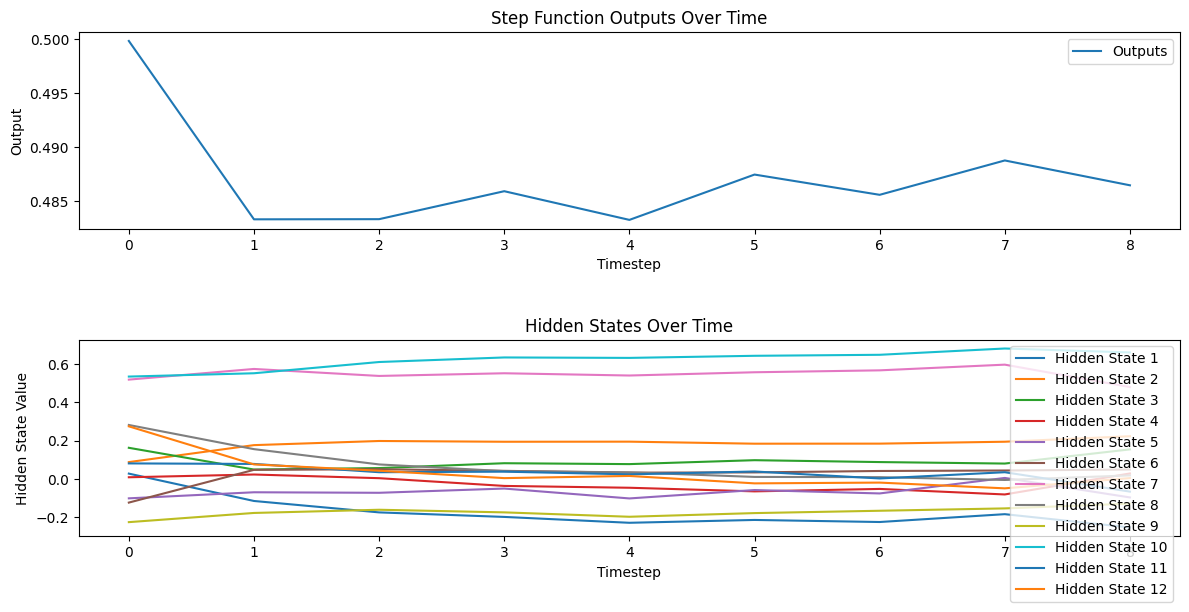

Analysis - Step Function Outputs: Mean = [0.48348513], Std Dev = [0.00698998]
Analysis - Step Function Hidden States: Mean = [-7.4932761e-02  1.5302579e-01 -2.0975496e-04  4.7017499e-03
 -1.3020069e-02 -1.9419393e-02  5.7931149e-01  1.0164893e-01
 -1.4637725e-01  6.3154525e-01  4.2149585e-02  7.6278843e-02], Std Dev = [0.07519495 0.04105106 0.07055667 0.04583794 0.03790952 0.05295584
 0.03688852 0.08736199 0.03201377 0.04448651 0.03586182 0.08203326]


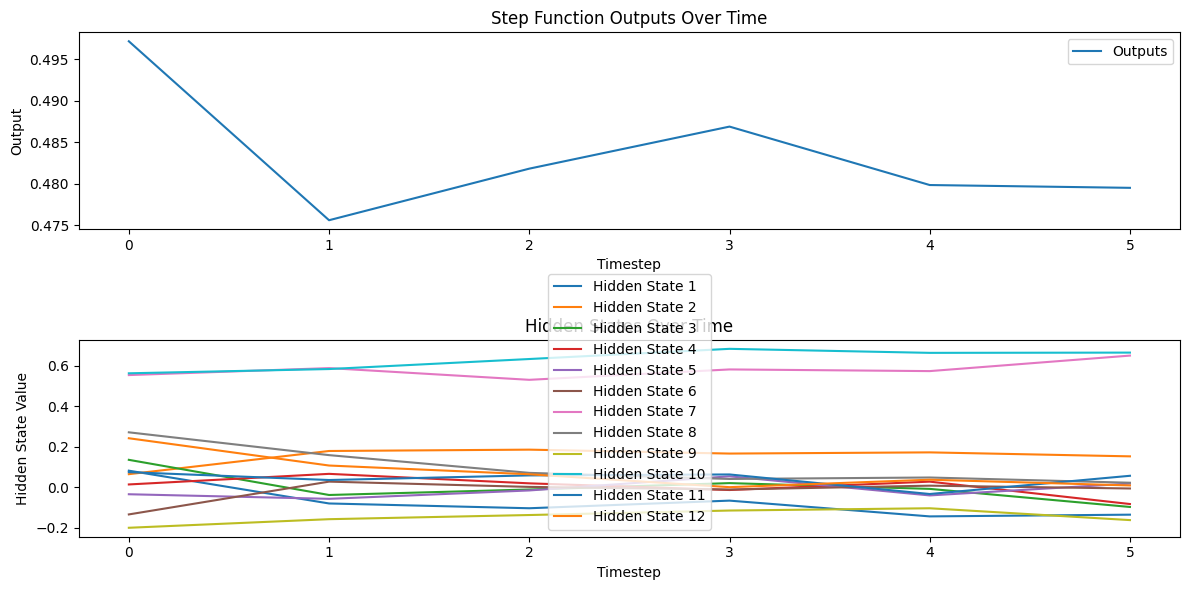

Analysis - Step Function Outputs: Mean = [0.46588016], Std Dev = [0.00547453]
Analysis - Step Function Hidden States: Mean = [-0.10049792  0.18727164 -0.0551366   0.04974635 -0.0339498  -0.01276017
  0.57652116  0.08021186 -0.15166137  0.6865902   0.01233804  0.04727805], Std Dev = [0.06545269 0.03705296 0.0580007  0.03115479 0.02710841 0.03976189
 0.03813693 0.07769945 0.03199174 0.03742903 0.02955226 0.06569572]


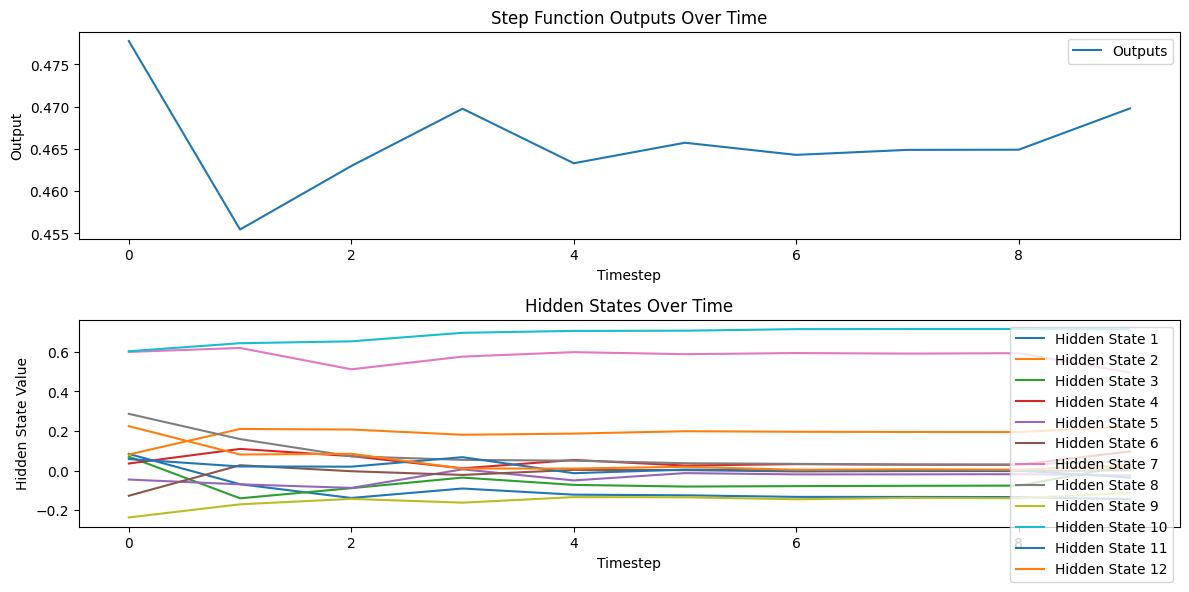

Analysis - Step Function Outputs: Mean = [0.4791255], Std Dev = [0.00281025]
Analysis - Step Function Hidden States: Mean = [-0.03269141  0.14493649 -0.04198945  0.0386804   0.01256444 -0.01405036
  0.5706243   0.05131993 -0.09013646  0.6852108  -0.00341381  0.03908797], Std Dev = [0.05190656 0.03223348 0.05225037 0.03132461 0.03893186 0.04348286
 0.03487676 0.08120323 0.05076291 0.04415897 0.0396337  0.0703463 ]


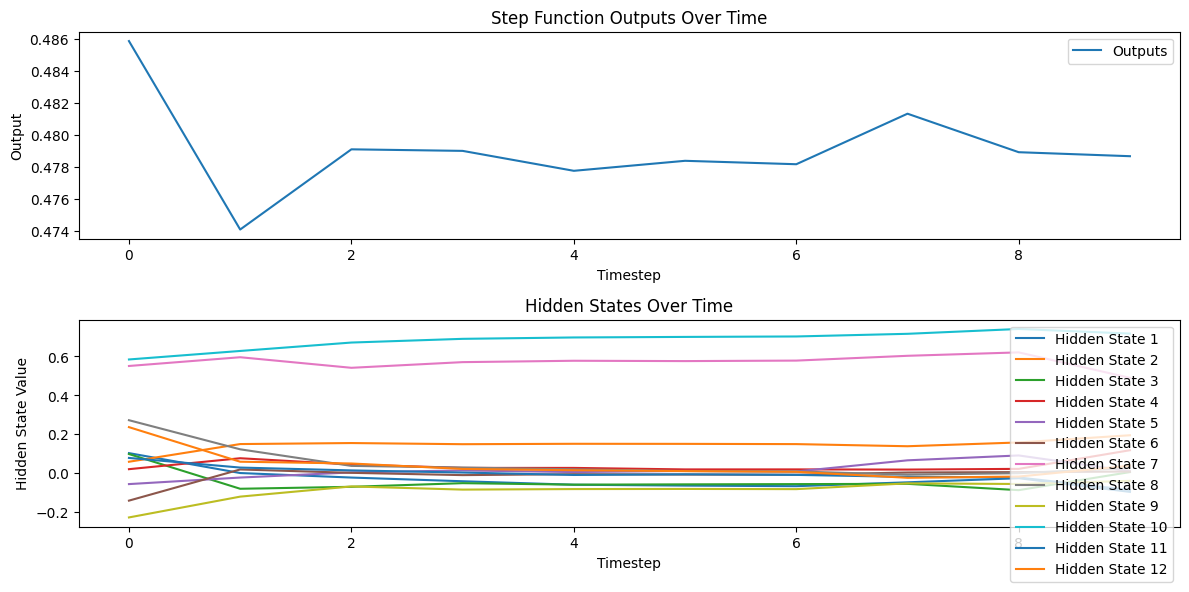

repeat
acc: 0.0
Analysis - Step Function Outputs: Mean = [0.488901], Std Dev = [0.00428555]
Analysis - Step Function Hidden States: Mean = [-0.11821136 -0.13490659 -0.06430764 -0.36970213 -0.05538008 -0.00947613
 -0.16034709 -0.15743595 -0.27346265 -0.14311618 -0.16902018  0.48755735], Std Dev = [0.03666221 0.03638449 0.03424636 0.02077144 0.07786378 0.10737805
 0.07776186 0.05715227 0.05111743 0.04860293 0.03495781 0.03994053]


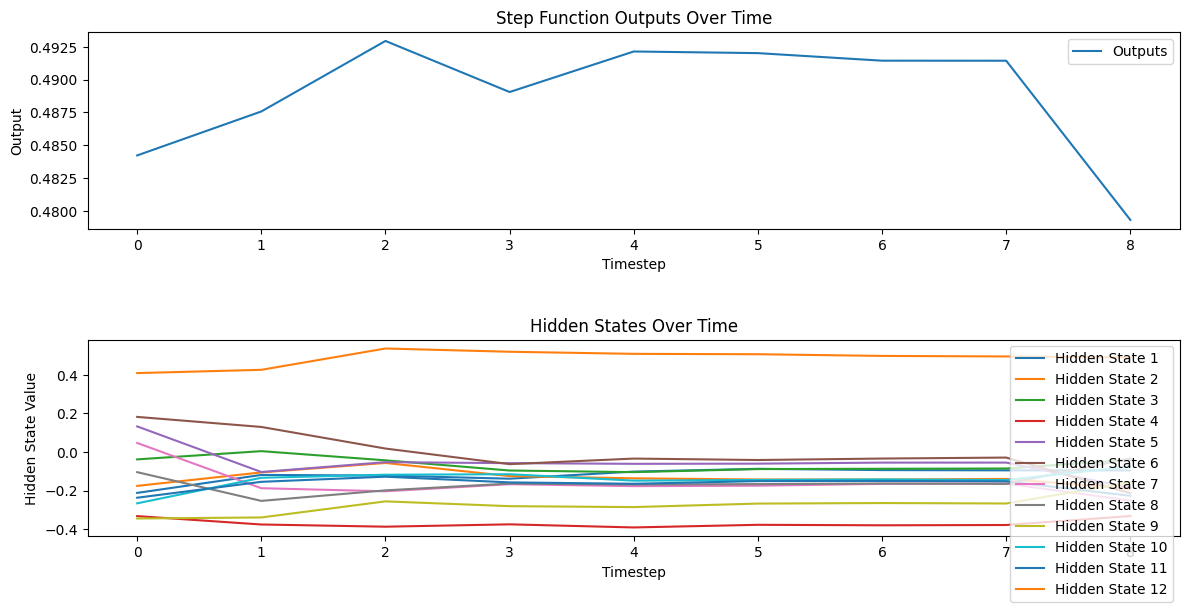

KeyboardInterrupt: 

In [60]:
# Parameters
array_min_length = 5
array_max_length = 10
analysis_interval = 500  # Interval for performing analysis

# Training Loop
for rep in range(1):
    model = NetRNNWithAttention(hidden_dim=12)
    optimizer = optim.Adam(model.parameters())
    error = nn.MSELoss()
    acc = 0.0
    W = []  # To store loss values
    A = []  # To store accuracy values

    iteration = 0
    while acc < 0.97:
        model.resetHidden()
        sequences, targets = generateTrainData(2, array_min_length, array_max_length)

        divs = []
        for seq, target in zip(sequences, targets):
            optimizer.zero_grad()
            seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0)
            target_tensor = torch.tensor([target], dtype=torch.float32)

            output = model(seq_tensor)
            loss = error(output, target_tensor)
            loss.backward()
            optimizer.step()

            div = output.detach().numpy() - target_tensor.numpy()
            divs.append(1.0 - abs(div).mean())

        W.append(loss.item())
        acc = mean(divs)
        A.append(acc)

        # Analysis Part
        if iteration % analysis_interval == 0:
            analysis_sequences, _ = generateTrainData(
                1, array_min_length, array_max_length
            )
            analysis_seq_tensor = torch.tensor(
                analysis_sequences[0], dtype=torch.float32
            ).unsqueeze(0)
            analysis_outputs, analysis_hidden_states = model.step(analysis_seq_tensor)

            # Logging
            # mean_outputs = analysis_outputs.mean(axis=0)
            # std_outputs = analysis_outputs.std(axis=0)
            # print(f"Analysis - Step Function Outputs: Mean = {mean_outputs}, Std Dev = {std_outputs}")

            # mean_hidden_states = analysis_hidden_states.mean(axis=0)
            # std_hidden_states = analysis_hidden_states.std(axis=0)
            # print(f"Analysis - Step Function Hidden States: Mean = {mean_hidden_states}, Std Dev = {std_hidden_states}")

            # Visualization
            # plt.figure(figsize=(12, 4))
            # plt.subplot(1, 2, 1)
            # plt.plot(analysis_outputs)
            # plt.title("Step Function Outputs Over Time")
            # plt.xlabel("Timestep")
            # plt.ylabel("Output")

            # plt.subplot(1, 2, 2)
            # plt.plot(analysis_hidden_states)
            # plt.title("Hidden States Over Time")
            # plt.xlabel("Timestep")
            # plt.ylabel("Hidden State Value")

            # plt.tight_layout()
            # plt.show()

        # Restart training if not converging
        if acc < 0.97 and len(A) > 2000:
            model = NetRNNWithAttention(hidden_dim=12)
            optimizer = optim.Adam(model.parameters())
            acc = 0.0
            W = []
            A = []
            print("repeat")
            print(f"acc: {acc}")

        iteration += 1

    print(f"RNN {rep}", len(A))

In [66]:
#### Batch processing #####
def generateTrainData(num_samples, min_length, max_length):
    sequences = []  # List to store sequences
    targets = []  # List to store targets

    for _ in range(num_samples):
        # Randomized length for each sequence in the batch
        length = np.random.randint(min_length, max_length + 1)

        # Initialize arrays A, B, and C
        array_A = np.full(length, 0.5)
        array_B = np.full(length, 0.5)
        array_C = np.full(length, 0.5)

        # Random index for array A
        index_A = np.random.randint(length)
        array_A[index_A] = np.random.choice([0, 1])

        # Different random index for array B
        indices_B = np.delete(np.arange(length), index_A)  # Exclude index_A
        index_B = np.random.choice(indices_B)
        array_B[index_B] = np.random.choice([0, 1])

        # Set the last index of array C to either 0 or 1
        array_C[-1] = np.random.choice([0, 1])

        # Generating label
        label = int(
            (array_A[index_A] != array_B[index_B])
            if array_C[-1] == 0
            else (array_A[index_A] == array_B[index_B])
        )

        # Combine arrays and append to lists
        combined_array = np.vstack([array_A, array_B, array_C]).T
        sequences.append(combined_array)
        targets.append(label)

    # Convert lists to arrays
    return np.array(sequences), np.array(targets)

In [67]:
# Assuming NetRNNWithAttention and generateTrainData are defined above this

# Parameters
array_min_length = 5
array_max_length = 10
batch_size = 32
validation_interval = 100
analysis_interval = 500


# Helper function to calculate accuracy
def calculate_accuracy(output, target):
    predictions = output.round()  # Assuming binary classification
    correct = (predictions == target).float()
    acc = correct.sum() / len(correct)
    return acc


# Training Loop
for rep in range(1):
    model = NetRNNWithAttention(hidden_dim=12)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.BCELoss()  # Assuming binary classification

    iteration = 0
    while True:
        model.resetHidden()

        # Training
        train_sequences, train_targets = generateTrainData(
            batch_size, array_min_length, array_max_length
        )
        train_seq_tensor = torch.tensor(train_sequences, dtype=torch.float32)
        train_target_tensor = torch.tensor(train_targets, dtype=torch.float32).squeeze()

        optimizer.zero_grad()
        train_output = model(train_seq_tensor)
        train_loss = criterion(train_output, train_target_tensor)
        train_loss.backward()
        optimizer.step()

        train_acc = calculate_accuracy(train_output, train_target_tensor)

        # Validation
        if iteration % validation_interval == 0:
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                val_sequences, val_targets = generateTrainData(
                    batch_size, array_min_length, array_max_length
                )
                val_seq_tensor = torch.tensor(val_sequences, dtype=torch.float32)
                val_target_tensor = torch.tensor(
                    val_targets, dtype=torch.float32
                ).squeeze()

                val_output = model(val_seq_tensor)
                val_loss = criterion(val_output, val_target_tensor)
                val_acc = calculate_accuracy(val_output, val_target_tensor)

                print(
                    f"Validation - Loss: {val_loss.item()}, Accuracy: {val_acc.item()}"
                )

            model.train()  # Set the model back to training mode

        # Analysis
        if iteration % analysis_interval == 0:
            analysis_sequences, _ = generateTrainData(
                1, array_min_length, array_max_length
            )
            analysis_seq_tensor = torch.tensor(
                analysis_sequences[0], dtype=torch.float32
            ).unsqueeze(0)
            analysis_outputs, analysis_hidden_states = model.step(analysis_seq_tensor)
            # Log or visualize analysis_outputs and analysis_hidden_states here
            # Logging
            # mean_outputs = analysis_outputs.mean(axis=0)
            # std_outputs = analysis_outputs.std(axis=0)
            # print(f"Analysis - Step Function Outputs: Mean = {mean_outputs}, Std Dev = {std_outputs}")

            # mean_hidden_states = analysis_hidden_states.mean(axis=0)
            # std_hidden_states = analysis_hidden_states.std(axis=0)
            # print(f"Analysis - Step Function Hidden States: Mean = {mean_hidden_states}, Std Dev = {std_hidden_states}")

            # Visualization
            # plt.figure(figsize=(12, 4))
            # plt.subplot(1, 2, 1)
            # plt.plot(analysis_outputs)
            # plt.title("Step Function Outputs Over Time")
            # plt.xlabel("Timestep")
            # plt.ylabel("Output")

            # plt.subplot(1, 2, 2)
            # plt.plot(analysis_hidden_states)
            # plt.title("Hidden States Over Time")
            # plt.xlabel("Timestep")
            # plt.ylabel("Hidden State Value")

            # plt.tight_layout()
            # plt.show()
        print(
            f"Iteration {iteration}, Training Loss: {train_loss.item()}, Accuracy: {train_acc.item()}"
        )

        iteration += 1
        if train_acc.item() >= 0.97:
            break  # Exit the loop if accuracy threshold is met

    print(f"RNN {rep} training complete in {iteration} iterations")

/var/folders/87/pnb9p7_n30s29gprj1gbqbbm0000gn/T/ipykernel_1799/2112459287.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(sequences), np.array(targets)


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.